<h1>Beyond Spell-Checking: Word-Checking</h1>
<h2>An attention based Transformer approach</h2>

<h2> Abdurrahman Shahid</h2>
<h3>L3 MIASHS - SC, University of Lille, France</h3>
<h3>Study and Research Work - Travaux d’Etude et de Recherche (TER) </h3>

<div> 
    <strong style="color:blue">Human performance was mesured through the following form: </strong>
    <a href="https://forms.gle/zY2wgV51tR5YKEcn7">https://forms.gle/zY2wgV51tR5YKEcn7</a>
</div>

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
import pickle
import copy
from datetime import datetime
from scipy import stats

In [2]:
HOMOPHONES = [
    ("a","à"),
    ("est","et"),
    ("ces","ses"),
    ("ce","se"),
    ("ou","où"),
    ("la","là"),
    ("tout","tous"),
    ("leur","leurs"),
    ("ceux","ce"),
    ("cette","cet")
]

## Filter data and keep one response per person (based on email)

In [3]:
def filter_by_email(df, inplace=False, save=True):
    emails = []
    index_to_filter = []
    for i in range(len(df)):
        email = df.iloc[i]['E-mail']
        if email is not np.nan:
            if email not in emails:
                emails.append(email)
            else:
                index_to_filter.append(i)
    #print("index filtered: {}".format(index_to_filter))
    print("mail filtered: \n{}".format(df['E-mail'][index_to_filter]))
    
    if inplace:
        df.drop(index_to_filter, inplace=True)
        df.index = range(len(df))
        if save:
            csv_name = "Forms_TER_filtered.csv"
            df.to_csv(csv_name, header=True, index=True, encoding="utf-8", sep=",")
            print("\nCSV file '{}' successfully saved.".format(csv_name))
    else:
        new_df = df.drop(index_to_filter, inplace=False)
        new_df.index = range(len(new_df))
        if save:
            csv_name = "Forms_TER_filtered.csv"
            df.to_csv(csv_name, header=True, index=True, encoding="utf-8", sep=",")
            print("\nCSV file '{}' successfully saved.".format(csv_name))
        return new_df

In [4]:
#answers_forms = pd.read_csv("Forms_TER.csv", header=0, encoding="utf-8")
#len(answers_forms), answers_forms.index

(87, RangeIndex(start=0, stop=87, step=1))

In [ ]:
#filter_by_email(answers_forms, inplace=True)

In [6]:
#len(answers_forms), answers_forms.index

(83, RangeIndex(start=0, stop=83, step=1))

In [7]:
questions_form = pd.read_csv("Google_forms_random.csv", index_col=0, header=0, encoding="utf-8", sep=";")
answers_forms = pd.read_csv("Forms_TER_filtered.csv", header=0, index_col=0,encoding="utf-8")

## Visualisation of respondants' attributes ##

In [8]:
def get_cumul_stats(df, column, order=[]):
    """Input: df is the answers csv"""
    
    di_order_index = {}
    
    for o in order:
        lio = list(df[column] == o)
        #print(lio)
        #index_o = []
        #for i in range(len(lio)):
            #if lio[i]:
                #index_o.append(i)
        di_order_index[o] =  sum(lio)
    
    counts = list(di_order_index.values())
    new_df = pd.DataFrame(counts, index=order, columns=["Counts"])
    
    percentage = list((np.array(counts)/np.array(counts).sum())*100)
    counts_cumul = [sum(counts[:i]) for i in range(1,len(counts)+1)]
    percentage_cumul = [sum(percentage[:i]) for i in range(1,len(percentage)+1)]
    
    new_df["Percentage"] = percentage
    new_df["Cumulative counts"] = counts_cumul
    new_df["Cumulative percentage"] = percentage_cumul
    
    return new_df

In [9]:
def plot_percentages(df, p=None, ylabel="",xlabel="",title="NUMBER", legend_labels=None, plt_text=False, save=False, dpi=200):
    df["Cumulative percentage"].plot.bar()
    df["Percentage"].plot.bar(color="red")
    if ylabel:
        plt.ylabel(ylabel)
    if xlabel:
        plt.xlabel(xlabel)
    plt.yticks(np.arange(0,110,10))
    if legend_labels:
        plt.legend(labels=legend_labels)
    else:
        plt.legend()
    
    #print(np.array((df["Cumulative percentage"])/p).round(1))
    #print(df.index[index_p])
    if p:
        plt.plot(range(0,len(df)),[p]*len(df), color="green")
        plt.text(0,p+1,"{}%".format(p), color="green")
        if not plt_text:
            index_p = np.argmin(np.abs(np.array((df["Cumulative percentage"])-p)))
            plt.text(len(df),p, "approx. <= {} years".format(df.index[index_p]))
    
    if plt_text:
        plt.text(len(df),90, plt_text)
        for i in range(1,len(df)+1):
            plt.text(len(df),90-i*10, "{} | {} % | {}".format(df["Counts"][i-1], round(df["Percentage"][i-1],1), df.index[i-1]))
    
    title = title.replace("NUMBER",str(list(df["Cumulative counts"])[-1]))
    plt.title(title)
    if save:
        plt.savefig("{}_{}.png".format(title,p), dpi=dpi, bbox_inches = 'tight')

In [10]:
def select_by_column(df, column="", criterion=None, csv_name=None, mail=False):
    """Input: df is the answers csv"""
    
    index_to_include = []
    index_to_exclude = []
    
    if not mail:
        for i in range(len(df)):
            col = df.iloc[i][column]
            if col in criterion:
                index_to_include.append(i)
            else:
                index_to_exclude.append(i)
    else:
        for i in range(len(df)):
            email = df.iloc[i][column]
            if email is not np.nan:
                index_to_include.append(i)
            else:
                index_to_exclude.append(i)
    
    print("\nNumber of items kept: {}\n".format(len(index_to_include)))
    
    new_df = df.drop(index_to_exclude, inplace=False)
    new_df.index = range(len(new_df))
    if csv_name:
        df.to_csv(csv_name, header=True, index=True, encoding="utf-8", sep=",")
        print("\nCSV file '{}' successfully saved.".format(csv_name))
    
    return new_df

In [11]:
study_level = get_cumul_stats(answers_forms,"Niveau d\'étude", ["Collège","Lycée","BAC","BAC + 1", "BAC + 2", "BAC + 3",
                                                     "BAC + 4", "BAC + 5","Supérieur à BAC + 5"])
study_level

,Counts,Percentage,Cumulative counts,Cumulative percentage
Collège,2,2.409639,2,2.409639
Lycée,19,22.891566,21,25.301205
BAC,5,6.024096,26,31.325301
BAC + 1,2,2.409639,28,33.734940
BAC + 2,15,18.072289,43,51.807229
BAC + 3,10,12.048193,53,63.855422
BAC + 4,8,9.638554,61,73.493976
BAC + 5,14,16.867470,75,90.361446
Supérieur à BAC + 5,8,9.638554,83,100.000000


In [12]:
a = list(set(answers_forms["Âge"]))

In [13]:
ages = get_cumul_stats(answers_forms,"Âge", a)
ages

,Counts,Percentage,Cumulative counts,Cumulative percentage
10,1,1.204819,1,1.204819
14,1,1.204819,2,2.409639
15,3,3.614458,5,6.024096
16,8,9.638554,13,15.662651
17,8,9.638554,21,25.301205
18,1,1.204819,22,26.506024
19,3,3.614458,25,30.120482
20,9,10.843373,34,40.963855
21,10,12.048193,44,53.012048
22,6,7.228916,50,60.240964


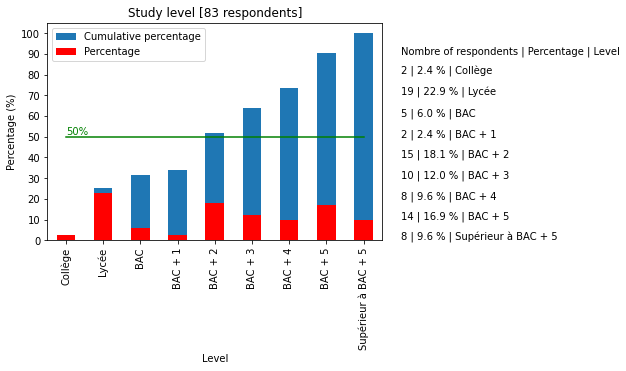

In [14]:
plot_percentages(study_level, p=50, title="Study level [NUMBER respondents]",ylabel="Percentage (%)",xlabel="Level",
                 plt_text="Nombre of respondents | Percentage | Level",
                 legend_labels=["Cumulative percentage","Percentage"], save=True)

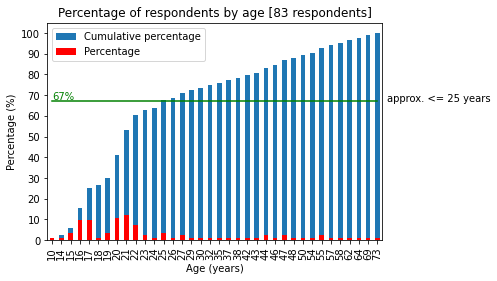

In [15]:
plot_percentages(ages, p=67, ylabel="Percentage (%)", xlabel="Age (years)",
                 title="Percentage of respondents by age [NUMBER respondents]",
                 legend_labels=["Cumulative percentage","Percentage"], save=True)

## Helper functions

In [16]:
def get_raw_counts(questions_df_in, answers_df, csv_name=None):
    
    questions_df = copy.deepcopy(questions_df_in)
    
    questions_df["TP"] = [None]*len(questions_df)
    questions_df["FP"] = [None]*len(questions_df)
    questions_df["TN"] = [None]*len(questions_df)
    questions_df["FN"] = [None]*len(questions_df)
    
    for i in answers_df.index.values:
        questions_df[i] = answers_df.iloc[i][4::2].apply(lambda s: s[:3]).values
    
    for i in answers_df.index.values:
        #print("index = {}".format(i))
        L = list((questions_df["True label"] == questions_df[i]).values)
        CT = list(questions_df["Correct Type"])
        ET = list(questions_df["Error Type"])
        questions_df[i] = [ct if l else et for l,ct,et in zip(L,CT,ET)]
    
    for i in range(len(questions_df)):
        counts_i = questions_df.iloc[i,10:].value_counts().values
        type_ans_i = questions_df.iloc[i,10:].value_counts().index.values
        di = {"TP":0,"FP":0,"TN":0,"FN":0}
        for key, val in zip(type_ans_i, counts_i):
            di[key] = val
        questions_df.iloc[i,6:10] = list(di.values())
        
    if csv_name:
        questions_df.to_csv(csv_name, header=True, index=True, encoding="utf-8", sep=",")
        print("\nCSV file '{}' successfully saved.".format(csv_name))
    
    return questions_df

In [17]:
def get_raw_scores(questions_df_in, answers_df, csv_name=None):
    
    questions_df = copy.deepcopy(questions_df_in)
    
    questions_df["TP"] = [None]*len(questions_df)
    questions_df["FP"] = [None]*len(questions_df)
    questions_df["TN"] = [None]*len(questions_df)
    questions_df["FN"] = [None]*len(questions_df)
    
    for i in answers_df.index.values:
        questions_df[i] = answers_df.iloc[i][4::2].apply(lambda s: s[:3]).values
    
    if csv_name:
        questions_df.to_csv(csv_name, header=True, index=True, encoding="utf-8", sep=",")
        print("\nCSV file '{}' successfully saved.".format(csv_name))
    
    return questions_df

In [18]:
def get_raw_confidences(questions_df_in, answers_df, csv_name=None):
    
    questions_df = copy.deepcopy(questions_df_in)
    
    questions_df["TP"] = [None]*len(questions_df)
    questions_df["FP"] = [None]*len(questions_df)
    questions_df["TN"] = [None]*len(questions_df)
    questions_df["FN"] = [None]*len(questions_df)
    
    for i in answers_df.index.values:
        questions_df[i] = answers_df.iloc[i][5::2].values
    
    if csv_name:
        questions_df.to_csv(csv_name, header=True, index=True, encoding="utf-8", sep=",")
        print("\nCSV file '{}' successfully saved.".format(csv_name))
    
    return questions_df

In [19]:
def get_raw_csc(questions_df_in, answers_df, csv_name_counts=None, csv_name_scores=None, csv_name_confidences=None):
    
    raw_counts = get_raw_counts(questions_df_in, answers_df, csv_name_counts) # (40,...)
    raw_scores = get_raw_scores(questions_df_in, answers_df, csv_name_scores) # (40,...)
    raw_confidences = get_raw_confidences(questions_df_in, answers_df, csv_name_confidences) # (40,..)
    
    return raw_counts, raw_scores, raw_confidences

In [20]:
def get_refined_counts(df_counts, csv_name=None, homophones=HOMOPHONES, columns=["TP","FP","TN","FN"]):
    """Input: raw counts"""
    
    homophones_reverse = [(b,a) for (a,b) in homophones]
    homophones_index = []
    for i in range(len(homophones)):
        homophones_index.append(homophones[i])
        homophones_index.append(homophones_reverse[i])
    
    df = pd.DataFrame(index=homophones_index, columns=columns)
    
    for i in range(0,len(homophones_index),2):
        index_correct = list(df_counts.index).index(str(homophones_index[i]))
        index_incorrect = list(df_counts.index).index(str(homophones_index[i+1])+'-incorrect')
        refined_counts_i = df_counts.iloc[index_correct,6:10] + df_counts.iloc[index_incorrect,6:10]
        df.iloc[i,:] = refined_counts_i
        
        index_correct = list(df_counts.index).index(str(homophones_index[i+1]))
        index_incorrect = list(df_counts.index).index(str(homophones_index[i])+'-incorrect')
        refined_counts_i = df_counts.iloc[index_correct,6:10] + df_counts.iloc[index_incorrect,6:10]
        df.iloc[i+1,:] = refined_counts_i
    
    if csv_name:
        df.to_csv(csv_name, header=True, index=True, encoding="utf-8", sep=",")
        print("\nCSV file '{}' successfully saved.".format(csv_name))
    
    return df

In [21]:
def get_refined_scores(df_scores, csv_name=None):
    """Input: raw scores"""
    id_scores = {}
    
    # individual scores (total sum)
    for i in df_scores.columns[10:].values:
        score_i = (df_scores[i] == df_scores["True label"]).sum()
        id_scores[i] = score_i
    
    scores = pd.DataFrame(id_scores.values(), index=id_scores.keys(), columns=["Scores"])
    
    # 1 = correct, 0 = incorrect; gives for each question the counts of correct and incorrect anwers
    for i in range(len(df_scores)):
        correctness_i = [1 if ans == df_scores["True label"][i] else 0 for ans in df_scores.iloc[i,10:].values]
        scores[i+1] = correctness_i
        
    
    if csv_name:
        scores.to_csv(csv_name, header=True, index=True, encoding="utf-8", sep=",")
        print("\nCSV file '{}' successfully saved.".format(csv_name))
    
    return scores

In [22]:
def get_refined_confidences(df_counts, df_confidences, csv_name=None, homophones=HOMOPHONES, columns=["TP","FP","TN","FN"]):
    """Input: raw counts and raw confidences"""
    homophones_reverse = [(b,a) for (a,b) in homophones]
    homophones_index = []
    for i in range(len(homophones)):
        homophones_index.append(homophones[i])
        homophones_index.append(homophones_reverse[i])
    
    df = pd.DataFrame(index=homophones_index, columns=columns)
    
    for i in range(0,len(homophones_index),2):
        
        index_correct = list(df_confidences.index).index(str(homophones_index[i]))
        index_incorrect = list(df_confidences.index).index(str(homophones_index[i+1])+'-incorrect')
        # (a,b)
        # FP and TN
        confidences_i = df_confidences.iloc[index_correct,10:].values
        labels_i = df_counts.iloc[index_correct,10:].values
        
        FP, TN = [], []
        for j in range(len(labels_i)):
            if labels_i[j] == "FP":
                FP.append(confidences_i[j])
            elif labels_i[j] == "TN":
                TN.append(confidences_i[j])
            else:
                print("ERREUR 1: pas de FP ni de TN dans labels.")
        
        nans = np.isnan(FP)
        nFP = []
        for k in range(len(nans)):
            if not nans[k]:
                nFP.append(FP[k])
        
        #print("TN : ",TN)        
        nans = np.isnan(TN)
        nTN = []
        for k in range(len(nans)):
            if not nans[k]:
                nTN.append(TN[k])
        #print("nTN  new: ",nTN)
        
        if len(nFP) != 0:
            fp = sum(nFP) / len(nFP)
        else:
            #print("nFP: ",nFP)
            fp = np.nan
        
        if len(nTN) != 0:
            tn = sum(nTN) / len(nTN)
            #print("tn : ", tn)
        else:
            #print("nTN Vide: ",nTN)
            tn = np.nan
        
        # TP and FN
        confidences_i = df_confidences.iloc[index_incorrect,10:].values
        labels_i = df_counts.iloc[index_incorrect,10:].values
        TP, FN = [], []
        for j in range(len(labels_i)):
            if labels_i[j] == "TP":
                TP.append(confidences_i[j])
            elif labels_i[j] == "FN":
                FN.append(confidences_i[j])
            else:
                print("ERREUR 2: pas de TP ni de FN dans labels.")
        
        nans = np.isnan(TP)
        nTP = []
        for k in range(len(nans)):
            if not nans[k]:
                nTP.append(TP[k])
        
        #print("FN: ", FN)        
        nans = np.isnan(FN)
        nFN = []
        for k in range(len(nans)):
            if not nans[k]:
                nFN.append(FN[k])
        #print("nFN : ", nFN)
        
        if len(nTP) != 0:
            tp = sum(nTP) / len(nTP)
        else:
            #print("TP: ",nTP)
            tp = np.nan
        
        if len(nFN) != 0:
            fn = sum(nFN) / len(nFN)
        else:
            #print("nFN: ",nFN)
            fn = np.nan
        
        refined_confidence_i = [tp,fp,tn,fn]
        df.iloc[i,:] = refined_confidence_i
        
        
        index_correct = list(df_counts.index).index(str(homophones_index[i+1]))
        index_incorrect = list(df_counts.index).index(str(homophones_index[i])+'-incorrect')
        #(b,a)
        # FP and TN
        confidences_i = df_confidences.iloc[index_correct,10:].values
        labels_i = df_counts.iloc[index_correct,10:].values
        FP, TN = [], []
        for j in range(len(labels_i)):
            if labels_i[j] == "FP":
                FP.append(confidences_i[j])
            elif labels_i[j] == "TN":
                TN.append(confidences_i[j])
            else:
                print("ERREUR 3: pas de FP ni de TN dans labels.")
        
        nans = np.isnan(FP)
        nFP = []
        for k in range(len(nans)):
            if not nans[k]:
                nFP.append(FP[k])
                
        #print("TN 2: ",TN)        
        nans = np.isnan(TN)
        nTN = []
        for k in range(len(nans)):
            if not nans[k]:
                nTN.append(TN[k])
        #print("nTN 2 new: ",nTN)
        
        if len(nFP) != 0:
            fp = sum(nFP) / len(nFP)
        else:
            print("nFP: ",nFP)
            fp = np.nan
        
        if len(nTN) != 0:
            tn = sum(nTN) / len(nTN)
            #print("tn 2:",tn)
        else:
            #print("nTN 2 vide: ",nTN)
            tn = np.nan
        
        # TP and FN
        confidences_i = df_confidences.iloc[index_incorrect,10:].values
        labels_i = df_counts.iloc[index_incorrect,10:].values
        TP, FN = [], []
        for j in range(len(labels_i)):
            if labels_i[j] == "TP":
                TP.append(confidences_i[j])
            elif labels_i[j] == "FN":
                FN.append(confidences_i[j])
            else:
                print("ERREUR 4: pas de TP ni de FN dans labels.")
        
        nans = np.isnan(TP)
        nTP = []
        for k in range(len(nans)):
            if not nans[k]:
                nTP.append(TP[k])
                
        #print("FN 2: ", FN)       
        nans = np.isnan(FN)
        nFN = []
        for k in range(len(nans)):
            if not nans[k]:
                nFN.append(FN[k])
        #print("nFN 2: ", nFN)
        
        if len(nTP) != 0:
            tp = sum(nTP) / len(nTP)
        else:
            #print("nTP: ",nTP)
            tp = np.nan
        
        if len(nFN) != 0:
            fn = sum(nFN) / len(nFN)
        else:
            #print("nFN: ",nFN)
            fn = np.nan
        
        refined_confidence_i = [tp,fp,tn,fn]
        df.iloc[i+1,:] = refined_confidence_i
    
    if csv_name:
        df.to_csv(csv_name, header=True, index=True, encoding="utf-8", sep=",")
        print("\nCSV file '{}' successfully saved.".format(csv_name))
        
    return df

In [23]:
def get_question_answers_proposition(answers_df, nb_q=40):
    
    di_q_ans = {}
    
    for q_counter in range(1,nb_q+1):
        key = "Q{}".format(q_counter)
        di_q_ans[q_counter] = list(answers_df[key].value_counts().index)
        
    
    return di_q_ans

In [24]:
def individual_results(ques_prop, qforms, answers_df, df_raw_scores, transformer_df=None):
    
    start_time = datetime.now()
    
    n = len(answers_df)
    rs = get_refined_scores(df_raw_scores)
    rs_mail = get_refined_scores(get_raw_scores(qforms, answers_df))
    
    for index in range(n):
        email = answers_df["E-mail"][index].strip()
        os.makedirs(email, exist_ok=True)
        
        score = 0
        score_model = 0
        
        for q_i in range(1,41):
            
            question = df_raw_scores["Sentence"][q_i-1]
            propositions = sorted(ques_prop[q_i], reverse=True)
            
            correct = rs.iloc[:,q_i].sum()
            incorrect = len(rs) - correct
            
            true = df_raw_scores["True label"][q_i-1]
            if true == "OUI":
                false = "NON"
                oui_color = "DarkTurquoise"
                non_color = "Brown"
            else:
                false = "OUI"
                non_color = "DarkTurquoise"
                oui_color = "Brown"
            
            mylabels = ["[{}-{}]".format(correct, true), "[{}-{}]".format(incorrect, false)]
            
            rep = answers_df["Q{}".format(q_i)][index]
            point = rs_mail.iloc[index,q_i]
            if point == 1:
                rep_color = "DarkTurquoise"
                score += 1
            else:
                rep_color = "Brown"
            
            rep_model = transformer_df["Answers"][q_i-1]
            point_model = transformer_df["Scores"][q_i-1]
            if point_model == 1:
                rep_color_model = "DarkTurquoise"
                score_model += 1
            else:
                rep_color_model = "Brown"
            
            
            if score > score_model:
                h_color = "SpringGreen"
                model_color = "Black"
            elif score < score_model:
                h_color = "Black"
                model_color = "SpringGreen"
            else:
                h_color, model_color = "Black", "Black"
            
            plt.clf()
            plt.pie([correct, incorrect], labels = mylabels, autopct='%1.0f%%', colors=["DarkTurquoise","Brown"])
            plt.title("Pensez-vous que cette phrase est correcte ?\nQ{}: {}".format(q_i,question))
            plt.text(2,1,"Propositions:")
            plt.text(2,0.8,"- {}".format(propositions[0]), color=oui_color)
            plt.text(2,0.6,"- {}".format(propositions[1]), color=non_color)
            plt.text(2,0.2,"Votre réponse [{}]: (+{} point)".format(email, point))
            plt.text(2,0,"- {}".format(rep), color=rep_color)
            plt.text(2,-0.2,"Sortie du modèle Transformer basé sur le Deep Learning: (+{} point)".format(point_model))
            plt.text(2,-0.4,"{}".format(rep_model), color=rep_color_model)
            plt.text(2,-0.8, "Votre score: /{}".format(q_i))
            plt.text(4,-0.8,"Modèle score: /{}".format(q_i))
            plt.text(2,-1,"{}".format(score), color=h_color)
            plt.text(4,-1,"{}".format(score_model), color=model_color)
            plt.legend(labels=["Bonne réponse","Mauvaise réponse"])
            plt.savefig(os.path.join(email,'{}.pdf'.format(q_i)), dpi=200, bbox_inches = 'tight')
    
    end_time = datetime.now()
    delta = end_time - start_time
    delta_minutes = delta.seconds // 60
    d = delta_minutes
    d_unit = "minutes"
    if delta_minutes == 0:
        d = delta.seconds
        d_unit = "seconds"
    print("\nDirectories and plots created with success (~{} {}).".format(d, d_unit))

In [25]:
def get_metrics(df,csv_name=False, percentage=False):
    
    df["Precision"] = (df["TP"] / (df["TP"] + df["FP"]))
    df["Recall"] = (df["TP"] / (df["TP"] + df["FN"]))
    df["Accuracy"] = ((df["TP"] + df["TN"])/ (df[df.columns[:-2]].sum(axis=1)))
    
    if percentage:
        df["Precision"] = df["Precision"] * 100
        df["Recall"] = df["Recall"] *100
        df["Accuracy"] = df["Accuracy"] * 100
    
    if csv_name:
        df.to_csv(csv_name, header=True, index=True, encoding="utf-8", sep=",")
        print("\nCSV file '{}' successfully saved.".format(csv_name))
    
    return df 

In [26]:
def compare_metrics(dfm, dfh, homophones, pv_limit=0.05, name_m="Transformer", name_h = "Humans", csv_base=False):
    
    homophones_reverse = [(b,a) for (a,b) in homophones]
    homophones_index = []
    for i in range(len(homophones)):
        homophones_index.append(homophones[i])
        homophones_index.append(homophones_reverse[i])
    
    best_bool = pd.DataFrame(index=homophones_index, columns=["Precision","Recall","Accuracy"])
    best_text = pd.DataFrame(index=homophones_index, columns=["Precision","Recall","Accuracy"])
    diff = pd.DataFrame(index=homophones_index, columns=["Precision","Recall","Accuracy"])
    
    Precision_diff = list(dfm["Precision"].values - dfh["Precision"].values) # model - humans
    Recall_diff = list(dfm["Recall"].values - dfh["Recall"].values)
    Accuracy_diff = list(dfm["Accuracy"].values - dfh["Accuracy"].values)
    
    Precision_bool = [True if pre>0 else False for pre in Precision_diff] # model - humans > 0, model wins
    Recall_bool = [True if rec>0 else False for rec in Recall_diff]
    Accuracy_bool = [True if acc>0 else False for acc in Accuracy_diff]
    
    Precision_text = [name_m if pre else name_h for pre in Precision_bool]
    Recall_text = [name_m if rec else name_h for rec in Recall_bool]
    Accuracy_text = [name_m if acc else name_h for acc in Accuracy_bool]
    
    best_bool["Precision"] = Precision_bool
    best_bool["Recall"] = Recall_bool
    best_bool["Accuracy"] = Accuracy_bool
    
    best_text["Precision"] = Precision_text
    best_text["Recall"] = Recall_text
    best_text["Accuracy"] = Accuracy_text
    
    diff["Precision"] = Precision_diff
    diff["Recall"] = Recall_diff
    diff["Accuracy"] = Accuracy_diff
    
    best_bool_pv = copy.deepcopy(best_bool)
    best_text_pv = copy.deepcopy(best_text)
    pvalues = pd.DataFrame(index=homophones_index, columns=["Precision","Recall","Accuracy"])
    alternatives = best_bool.replace({True:'less',False:'greater'})
    # hypothesis testing, H0: model = humans
    # alternativs: if model - humans > 0, 'less'; else 'greater'
    for metric in ["Precision","Recall","Accuracy"]:
        pv_metric = []
        if metric == 'Precision':
            X = dfh["TP"]
            N = dfh["TP"] + dfh["FP"]
        elif metric == 'Recall':
            X = dfh["TP"]
            N = dfh["TP"] + dfh["FN"]
        else:
            X = dfh["TP"] + dfh["TN"]
            N = dfh["TP"] + dfh["FP"] + dfh["TN"] + dfh["FN"]

        for ind in range(len(best_bool_pv)):
            pv = stats.binom_test(X[ind], N[ind], dfm[metric][ind], alternatives[metric][ind])
            pv_metric.append(pv)
        pvalues[metric] = pv_metric
    
    new_prec_bool = [Precision_bool[i] if pvalues["Precision"][i] < pv_limit else "Undecided" for i in range(len(pvalues))]
    new_rec_bool = [Recall_bool[i] if pvalues["Recall"][i] < pv_limit else "Undecided" for i in range(len(pvalues))]
    new_acc_bool = [Accuracy_bool[i] if pvalues["Accuracy"][i] < pv_limit else "Undecided" for i in range(len(pvalues))]
    
    best_bool_pv["Precision"] = new_prec_bool
    best_bool_pv["Recall"] = new_rec_bool
    best_bool_pv["Accuracy"] = new_acc_bool
    
    best_text_pv = best_bool_pv.replace({True:name_m, False:name_h})
    
    if csv_base:
        os.makedirs(csv_base)
        csv_name = csv_base + "_Bool.csv"
        csv_name = os.path.join(csv_base, csv_name)
        best_bool.to_csv(csv_name, header=True, index=True, encoding="utf-8", sep=",")
        print("\nCSV file '{}' successfully saved.".format(csv_name))
        
        csv_name = csv_base + "_Text.csv"
        csv_name = os.path.join(csv_base, csv_name)
        best_text.to_csv(csv_name, header=True, index=True, encoding="utf-8", sep=",")
        print("\nCSV file '{}' successfully saved.".format(csv_name))
        
        csv_name = csv_base + "_Diff.csv"
        csv_name = os.path.join(csv_base, csv_name)
        diff.to_csv(csv_name, header=True, index=True, encoding="utf-8", sep=",")
        print("\nCSV file '{}' successfully saved.".format(csv_name))
        
        csv_name = csv_base + "_Bool_pv{}.csv".format(pv_limit)
        csv_name = os.path.join(csv_base, csv_name)
        best_bool_pv.to_csv(csv_name, header=True, index=True, encoding="utf-8", sep=",")
        print("\nCSV file '{}' successfully saved.".format(csv_name))
        
        csv_name = csv_base + "_Text_pv{}.csv".format(pv_limit)
        csv_name = os.path.join(csv_base, csv_name)
        best_text_pv.to_csv(csv_name, header=True, index=True, encoding="utf-8", sep=",")
        print("\nCSV file '{}' successfully saved.".format(csv_name))
        
        csv_name = csv_base + "_pvalues{}.csv".format(pv_limit)
        csv_name = os.path.join(csv_base, csv_name)
        pvalues.to_csv(csv_name, header=True, index=True, encoding="utf-8", sep=",")
        print("\nCSV file '{}' successfully saved.".format(csv_name))
        
        csv_name = csv_base + "_alternatives{}.csv".format(pv_limit)
        csv_name = os.path.join(csv_base, csv_name)
        alternatives.to_csv(csv_name, header=True, index=True, encoding="utf-8", sep=",")
        print("\nCSV file '{}' successfully saved.".format(csv_name))
        
        
    
    return best_bool, best_text, diff, best_bool_pv, best_text_pv, pvalues, alternatives

## Get individual results (to send them by email)

In [27]:
#answers_w_email = select_by_column(answers_forms,"E-mail",mail=True)
#answers_w_email.head(2)

In [28]:
#question_propositions = get_question_answers_proposition(answers_forms)
#question_propositions[4].append('OUI : la phrase est correcte.')

In [29]:
#dftransformer = pd.read_csv("test_sentence_ggle_forms_transformer_results.csv", header=0, index_col=0, encoding="utf-8")
#dftransformer[:3]

In [30]:
#_,raw_scores,_ = get_raw_csc(questions_form,answers_forms)

In [31]:
#individual_results(question_propositions,questions_form,answers_w_email,raw_scores, dftransformer)

### Anonimize E-mail column ###

In [32]:
#answers_forms = pd.read_csv("Forms_TER_filtered.csv", header=0, index_col=0,encoding="utf-8")

In [33]:
#answers_forms["E-mail"] = [None] * len(answers_forms)
#csv_name = "Forms_TER_filtered.csv"
#answers_forms.to_csv(csv_name, header=True, index=True, encoding="utf-8", sep=",")

In [34]:
#answers_forms = pd.read_csv("Forms_TER_filtered.csv", header=0, index_col=0,encoding="utf-8")
answers_forms.head(2)

,Horodateur,Âge,Niveau d'étude,E-mail,Q1,Q1b - À quel point êtes-vous confiant(e) de votre précédente réponse ?,Q2,Q2b - À quel point êtes-vous confiant(e) de votre précédente réponse ?,Q3,Q3b - À quel point êtes-vous confiant(e) de votre précédente réponse ?,...,Q36,Q36b - À quel point êtes-vous confiant(e) de votre précédente réponse ?,Q37,Q37b - À quel point êtes-vous confiant(e) de votre précédente réponse ?,Q38,Q38b - À quel point êtes-vous confiant(e) de votre précédente réponse ?,Q39,Q39b - À quel point êtes-vous confiant(e) de votre précédente réponse ?,Q40,Q40b - À quel point êtes-vous confiant(e) de votre précédente réponse ?
0,31/01/2021 16:11:50,27,Supérieur à BAC + 5,NaN,"NON : la phrase n'est pas correcte, il faut re...",10,"NON : la phrase n'est pas correcte, il faut re...",8.0,"NON : la phrase n'est pas correcte, il faut re...",10.0,...,"NON : la phrase n'est pas correcte, il faut re...",10.0,OUI : la phrase est correcte.,10.0,"NON : la phrase n'est pas correcte, il faut re...",8.0,OUI : la phrase est correcte.,10.0,OUI : la phrase est correcte.,8.0
1,31/01/2021 17:14:46,20,BAC + 2,NaN,"NON : la phrase n'est pas correcte, il faut re...",10,"NON : la phrase n'est pas correcte, il faut re...",8.0,"NON : la phrase n'est pas correcte, il faut re...",10.0,...,"NON : la phrase n'est pas correcte, il faut re...",10.0,OUI : la phrase est correcte.,5.0,"NON : la phrase n'est pas correcte, il faut re...",10.0,OUI : la phrase est correcte.,5.0,OUI : la phrase est correcte.,5.0


# Performance comparison between the Tranformer and humans

## Confidence scores (all respondents)

In [35]:
x,y,z = get_raw_csc(questions_form,answers_forms)
z_refined = get_refined_confidences(x,z)
z_refined

,TP,FP,TN,FN
"(a, à)",9.80519,7,9.53947,8.6
"(à, a)",9.74359,8.4,9.61039,9.75
"(est, et)",9.84,6.5,9.8125,8.42857
"(et, est)",10,7.71429,9.52,8.5
"(ces, ses)",9.38889,7.75,8.83333,9.33333
"(ses, ces)",9.17391,8,9.2963,7.46154
"(ce, se)",9.44156,10,9.67089,7.66667
"(se, ce)",9.89474,9,9.64557,7.83333
"(ou, où)",9.60563,9.25,9.5,9.72727
"(où, ou)",9.73418,8.2,9.39474,8


In [36]:
z_refined.mean(axis=0)

TP    9.587097
FP    7.988284
TN    9.492825
FN    8.289684
dtype: float64

## Comparison with all respondents

In [37]:
x,y,z = get_raw_csc(questions_form,answers_forms)

In [38]:
y_refined = get_refined_scores(y)
y_refined

,Scores,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,40,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,37,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,39,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,38,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1,1,1
4,40,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,39,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
79,40,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
80,40,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
81,40,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [39]:
index_scores = sorted(list(set(y_refined["Scores"].value_counts().index)))
index_scores

[20, 25, 26, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40]

In [40]:
scores_summary = get_cumul_stats(y_refined,"Scores",index_scores)
percentages = scores_summary["Percentage"]
scores_summary["Reverse cumulative percentage"] = [sum(percentages[i:]) for i in range(len(percentages))]
scores_summary

,Counts,Percentage,Cumulative counts,Cumulative percentage,Reverse cumulative percentage
20,2,2.409639,2,2.409639,100.000000
25,1,1.204819,3,3.614458,97.590361
26,1,1.204819,4,4.819277,96.385542
29,2,2.409639,6,7.228916,95.180723
30,2,2.409639,8,9.638554,92.771084
31,1,1.204819,9,10.843373,90.361446
33,1,1.204819,10,12.048193,89.156627
34,4,4.819277,14,16.867470,87.951807
35,2,2.409639,16,19.277108,83.132530
36,6,7.228916,22,26.506024,80.722892


In [41]:
data = [
    scores_summary.iloc[13]["Counts"].sum(), scores_summary.iloc[12]["Counts"].sum(), 
    scores_summary.iloc[11]["Counts"].sum(), scores_summary.iloc[10]["Counts"].sum(), 
    scores_summary.iloc[9]["Counts"].sum(), scores_summary.iloc[4:9]["Counts"].sum(),
    scores_summary.iloc[:4]["Counts"].sum()
]
mylabels = ["40","39","38","37","36","30-35","20-29"]

In [42]:
def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(matplotlib.colors.to_rgb(c1))
    c2=np.array(matplotlib.colors.to_rgb(c2))
    return matplotlib.colors.to_hex((1-mix)*c1 + mix*c2)

c1= "DarkTurquoise"
c2= 'FloralWhite'
n=7

colors = [colorFader(c1,c2,i/n) for i in range(1,8)]

[]

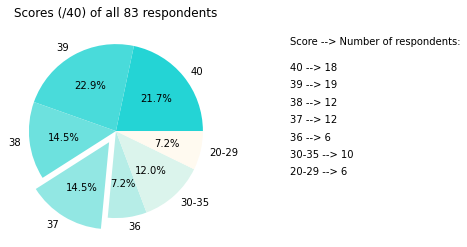

In [43]:
plt.title("Scores (/40) of all {} respondents".format(int(sum(data))))
plt.pie(data, labels = mylabels, explode=[0,0,0,0.15,0,0,0], autopct='%0.1f%%', colors=colors)
plt.text(2,1,"Score --> Number of respondents:")
for i in range(len(mylabels)):
    plt.text(2,0.7-i*0.2,"{} --> {}".format(mylabels[i],int(data[i])))
plt.savefig("pie_{}.png".format(int(sum(data))), dpi=200, bbox_inches="tight")
plt.plot()

In [44]:
humans = get_refined_counts(x)
#humans = get_metrics(humans, csv_name="All_respondent_metrics.csv")
humans = get_metrics(humans)
humans

,TP,FP,TN,FN,Precision,Recall,Accuracy
"(a, à)",78,7,76,5,0.917647,0.939759,0.927711
"(à, a)",79,5,78,4,0.940476,0.951807,0.945783
"(est, et)",76,3,80,7,0.962025,0.915663,0.939759
"(et, est)",79,7,76,4,0.918605,0.951807,0.933735
"(ces, ses)",73,16,67,10,0.820225,0.879518,0.843373
"(ses, ces)",70,1,82,13,0.985915,0.843373,0.915663
"(ce, se)",77,3,80,6,0.9625,0.927711,0.945783
"(se, ce)",77,3,80,6,0.9625,0.927711,0.945783
"(ou, où)",72,4,79,11,0.947368,0.86747,0.909639
"(où, ou)",80,6,77,3,0.930233,0.963855,0.945783


In [45]:
humans.mean(axis=0)

TP           75.100000
FP            5.300000
TN           77.700000
FN            7.900000
Precision     0.935286
Recall        0.904819
Accuracy      0.920482
dtype: float64

In [46]:
model = pd.read_csv("Counts-2-8-22-50.csv", header=0, index_col=0,encoding="utf-8")
model = get_metrics(model)
model

,TP,FP,TN,FN,Unexpected,Precision,Recall,Accuracy
"('a', 'à')",407,7,489,87,10,0.983092,0.823887,0.896
"('à', 'a')",428,2,493,63,14,0.995349,0.871690,0.921
"('est', 'et')",395,33,464,89,19,0.922897,0.816116,0.859
"('et', 'est')",303,4,495,183,15,0.986971,0.623457,0.798
"('ces', 'ses')",368,53,440,127,12,0.874109,0.743434,0.808
"('ses', 'ces')",306,34,456,187,17,0.900000,0.620690,0.762
"('ce', 'se')",437,2,488,59,14,0.995444,0.881048,0.925
"('se', 'ce')",426,3,497,62,12,0.993007,0.872951,0.923
"('ou', 'où')",455,27,468,36,14,0.943983,0.926680,0.923
"('où', 'ou')",447,33,464,52,4,0.931250,0.895792,0.911


In [47]:
model.mean(axis=0)

TP            432.950000
FP             18.400000
TN            476.850000
FN             60.400000
Unexpected     11.400000
Precision       0.958978
Recall          0.877176
Accuracy        0.909800
dtype: float64

In [48]:
best_bool, best_text, diff, best_bool_pv, best_text_pv, pvalues, alternatives = compare_metrics(model, humans, HOMOPHONES, pv_limit=0.05, csv_base="Comparison_all_respondent")


CSV file 'Comparison_all_respondent\Comparison_all_respondent_Bool.csv' successfully saved.

CSV file 'Comparison_all_respondent\Comparison_all_respondent_Text.csv' successfully saved.

CSV file 'Comparison_all_respondent\Comparison_all_respondent_Diff.csv' successfully saved.

CSV file 'Comparison_all_respondent\Comparison_all_respondent_Bool_pv0.05.csv' successfully saved.

CSV file 'Comparison_all_respondent\Comparison_all_respondent_Text_pv0.05.csv' successfully saved.

CSV file 'Comparison_all_respondent\Comparison_all_respondent_pvalues0.05.csv' successfully saved.

CSV file 'Comparison_all_respondent\Comparison_all_respondent_alternatives0.05.csv' successfully saved.


#### results without considering pvalues

In [49]:
best_text

,Precision,Recall,Accuracy
"(a, à)",Transformer,Humans,Humans
"(à, a)",Transformer,Humans,Humans
"(est, et)",Humans,Humans,Humans
"(et, est)",Transformer,Humans,Humans
"(ces, ses)",Transformer,Humans,Humans
"(ses, ces)",Humans,Humans,Humans
"(ce, se)",Transformer,Humans,Humans
"(se, ce)",Transformer,Humans,Humans
"(ou, où)",Humans,Transformer,Transformer
"(où, ou)",Transformer,Humans,Humans


In [50]:
diff

,Precision,Recall,Accuracy
"(a, à)",0.065445,-0.115872,-0.031711
"(à, a)",0.054873,-0.080117,-0.024783
"(est, et)",-0.039128,-0.099547,-0.080759
"(et, est)",0.068366,-0.328350,-0.135735
"(ces, ses)",0.053885,-0.136084,-0.035373
"(ses, ces)",-0.085915,-0.222684,-0.153663
"(ce, se)",0.032944,-0.046662,-0.020783
"(se, ce)",0.030507,-0.054760,-0.022783
"(ou, où)",-0.003385,0.059210,0.013361
"(où, ou)",0.001017,-0.068064,-0.034783


#### results after considering statistaical (binomial exact test) test and pvalues

In [51]:
best_bool_pv

,Precision,Recall,Accuracy
"(a, à)",True,False,Undecided
"(à, a)",True,False,Undecided
"(est, et)",Undecided,False,False
"(et, est)",True,False,False
"(ces, ses)",Undecided,False,Undecided
"(ses, ces)",False,False,False
"(ce, se)",True,Undecided,Undecided
"(se, ce)",True,Undecided,Undecided
"(ou, où)",Undecided,True,Undecided
"(où, ou)",Undecided,False,Undecided


In [52]:
best_text_pv

,Precision,Recall,Accuracy
"(a, à)",Transformer,Humans,Undecided
"(à, a)",Transformer,Humans,Undecided
"(est, et)",Undecided,Humans,Humans
"(et, est)",Transformer,Humans,Humans
"(ces, ses)",Undecided,Humans,Undecided
"(ses, ces)",Humans,Humans,Humans
"(ce, se)",Transformer,Undecided,Undecided
"(se, ce)",Transformer,Undecided,Undecided
"(ou, où)",Undecided,Transformer,Undecided
"(où, ou)",Undecided,Humans,Undecided


In [53]:
pvalues

,Precision,Recall,Accuracy
"(a, à)",0.000617,1.857950e-03,1.090977e-01
"(à, a)",0.000050,1.394496e-02,1.477381e-01
"(est, et)",0.132869,9.217419e-03,8.213202e-04
"(et, est)",0.000139,2.476711e-12,9.516293e-07
"(ces, ses)",0.089277,1.897768e-03,1.441472e-01
"(ses, ces)",0.005013,7.940632e-06,2.348666e-07
"(ce, se)",0.005983,1.224999e-01,1.948912e-01
"(se, ce)",0.018846,8.446298e-02,1.700877e-01
"(ou, où)",0.577304,3.988116e-02,2.977754e-01
"(où, ou)",0.545478,2.173423e-02,6.830788e-02


In [54]:
alternatives # alternative hypothesis for statistical tests

,Precision,Recall,Accuracy
"(a, à)",less,greater,greater
"(à, a)",less,greater,greater
"(est, et)",greater,greater,greater
"(et, est)",less,greater,greater
"(ces, ses)",less,greater,greater
"(ses, ces)",greater,greater,greater
"(ce, se)",less,greater,greater
"(se, ce)",less,greater,greater
"(ou, où)",greater,less,less
"(où, ou)",less,greater,greater


#### Count the victories 

In [55]:
for winner in ["Transformer","Humans","Undecided"]:
    print(winner)
    print((best_text_pv == winner).sum())
    print((best_text_pv == winner).sum().sum())
    print("")

Transformer
Precision    9
Recall       7
Accuracy     4
dtype: int64
20

Humans
Precision    1
Recall       8
Accuracy     3
dtype: int64
12

Undecided
Precision    10
Recall        5
Accuracy     13
dtype: int64
28



## Comparison when study level is under BAC+2

In [56]:
answers_bac2 = select_by_column(answers_forms,"Niveau d\'étude",["Collège","Lycée","BAC","BAC + 1", "BAC + 2"],
                csv_name="Forms_TER_filtered_study_under_bac_2.csv")

x,y,z = get_raw_csc(questions_form,answers_bac2)
y_refined = get_refined_scores(y)


index_scores = sorted(list(set(y_refined["Scores"].value_counts().index)))
scores_summary = get_cumul_stats(y_refined,"Scores",index_scores)
percentages = scores_summary["Percentage"]
scores_summary["Reverse cumulative percentage"] = [sum(percentages[i:]) for i in range(len(percentages))]
scores_summary


Number of items kept: 43


CSV file 'Forms_TER_filtered_study_under_bac_2.csv' successfully saved.


,Counts,Percentage,Cumulative counts,Cumulative percentage,Reverse cumulative percentage
20,2,4.651163,2,4.651163,100.000000
25,1,2.325581,3,6.976744,95.348837
26,1,2.325581,4,9.302326,93.023256
29,1,2.325581,5,11.627907,90.697674
30,2,4.651163,7,16.279070,88.372093
31,1,2.325581,8,18.604651,83.720930
33,1,2.325581,9,20.930233,81.395349
34,3,6.976744,12,27.906977,79.069767
35,1,2.325581,13,30.232558,72.093023
36,4,9.302326,17,39.534884,69.767442


[]

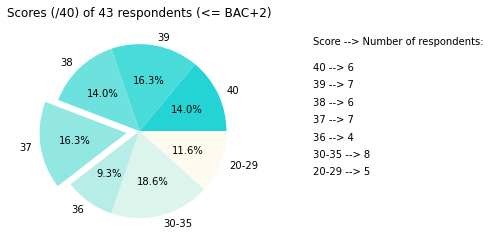

In [57]:
data = [
    scores_summary.iloc[13]["Counts"].sum(), scores_summary.iloc[12]["Counts"].sum(), 
    scores_summary.iloc[11]["Counts"].sum(), scores_summary.iloc[10]["Counts"].sum(), 
    scores_summary.iloc[9]["Counts"].sum(), scores_summary.iloc[4:9]["Counts"].sum(),
    scores_summary.iloc[:4]["Counts"].sum()
]
mylabels = ["40","39","38","37","36","30-35","20-29"]

def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(matplotlib.colors.to_rgb(c1))
    c2=np.array(matplotlib.colors.to_rgb(c2))
    return matplotlib.colors.to_hex((1-mix)*c1 + mix*c2)

c1= "DarkTurquoise"
c2= 'FloralWhite'
n=7

colors = [colorFader(c1,c2,i/n) for i in range(1,8)]

plt.title("Scores (/40) of {} respondents (<= BAC+2)".format(int(sum(data))))
plt.pie(data, labels = mylabels, explode=[0,0,0,0.15,0,0,0], autopct='%0.1f%%', colors=colors)
plt.text(2,1,"Score --> Number of respondents:")
for i in range(len(mylabels)):
    plt.text(2,0.7-i*0.2,"{} --> {}".format(mylabels[i],int(data[i])))
plt.savefig("pie_under_bac_2_{}.png".format(int(sum(data))), dpi=200, bbox_inches="tight")
plt.plot()

In [58]:
humans = get_refined_counts(x)
humans = get_metrics(humans)
humans

,TP,FP,TN,FN,Precision,Recall,Accuracy
"(a, à)",39,7,36,4,0.847826,0.906977,0.872093
"(à, a)",40,5,38,3,0.888889,0.930233,0.906977
"(est, et)",37,3,40,6,0.925,0.860465,0.895349
"(et, est)",40,7,36,3,0.851064,0.930233,0.883721
"(ces, ses)",38,8,35,5,0.826087,0.883721,0.848837
"(ses, ces)",35,0,43,8,1,0.813953,0.906977
"(ce, se)",38,1,42,5,0.974359,0.883721,0.930233
"(se, ce)",37,1,42,6,0.973684,0.860465,0.918605
"(ou, où)",35,4,39,8,0.897436,0.813953,0.860465
"(où, ou)",41,5,38,2,0.891304,0.953488,0.918605


In [59]:
humans.astype(float).mean(axis=0)

TP           37.150000
FP            3.900000
TN           39.100000
FN            5.850000
Precision     0.907985
Recall        0.863953
Accuracy      0.886628
dtype: float64

In [60]:
model = pd.read_csv("Counts-2-8-22-50.csv", header=0, index_col=0,encoding="utf-8")
model = get_metrics(model)
model

,TP,FP,TN,FN,Unexpected,Precision,Recall,Accuracy
"('a', 'à')",407,7,489,87,10,0.983092,0.823887,0.896
"('à', 'a')",428,2,493,63,14,0.995349,0.871690,0.921
"('est', 'et')",395,33,464,89,19,0.922897,0.816116,0.859
"('et', 'est')",303,4,495,183,15,0.986971,0.623457,0.798
"('ces', 'ses')",368,53,440,127,12,0.874109,0.743434,0.808
"('ses', 'ces')",306,34,456,187,17,0.900000,0.620690,0.762
"('ce', 'se')",437,2,488,59,14,0.995444,0.881048,0.925
"('se', 'ce')",426,3,497,62,12,0.993007,0.872951,0.923
"('ou', 'où')",455,27,468,36,14,0.943983,0.926680,0.923
"('où', 'ou')",447,33,464,52,4,0.931250,0.895792,0.911


In [61]:
model.mean(axis=0)

TP            432.950000
FP             18.400000
TN            476.850000
FN             60.400000
Unexpected     11.400000
Precision       0.958978
Recall          0.877176
Accuracy        0.909800
dtype: float64

In [62]:
best_bool, best_text, diff, best_bool_pv, best_text_pv, pvalues, alternatives = compare_metrics(model, humans, HOMOPHONES, pv_limit=0.05)

#### results after considering statistaical test (binomial exact test) and pvalues

In [63]:
best_text_pv

,Precision,Recall,Accuracy
"(a, à)",Transformer,Undecided,Undecided
"(à, a)",Transformer,Undecided,Undecided
"(est, et)",Undecided,Undecided,Undecided
"(et, est)",Transformer,Humans,Humans
"(ces, ses)",Undecided,Humans,Undecided
"(ses, ces)",Humans,Humans,Humans
"(ce, se)",Undecided,Undecided,Undecided
"(se, ce)",Undecided,Undecided,Undecided
"(ou, où)",Undecided,Transformer,Transformer
"(où, ou)",Undecided,Undecided,Undecided


In [64]:
pvalues

,Precision,Recall,Accuracy
"(a, à)",0.000012,1.036139e-01,2.802542e-01
"(à, a)",0.000002,1.806279e-01,3.692511e-01
"(est, et)",0.627741,3.004249e-01,2.115177e-01
"(et, est)",0.000003,4.618907e-06,2.692590e-02
"(ces, ses)",0.216470,2.061989e-02,2.073723e-01
"(ses, ces)",0.025032,5.292516e-03,4.883105e-04
"(ce, se)",0.163127,5.947175e-01,5.316624e-01
"(se, ce)",0.234072,4.700932e-01,4.964728e-01
"(ou, où)",0.172913,1.192682e-02,3.198285e-02
"(où, ou)",0.207304,1.605119e-01,4.977935e-01


In [65]:
alternatives # alternative hypothesis for statistical tests

,Precision,Recall,Accuracy
"(a, à)",less,greater,less
"(à, a)",less,greater,less
"(est, et)",greater,greater,greater
"(et, est)",less,greater,greater
"(ces, ses)",less,greater,greater
"(ses, ces)",greater,greater,greater
"(ce, se)",less,greater,greater
"(se, ce)",less,less,less
"(ou, où)",less,less,less
"(où, ou)",less,greater,greater


#### Count the victories 

In [66]:
for winner in ["Transformer","Humans","Undecided"]:
    print(winner)
    print((best_text_pv == winner).sum())
    print((best_text_pv == winner).sum().sum())
    print("")

Transformer
Precision    6
Recall       8
Accuracy     6
dtype: int64
20

Humans
Precision    1
Recall       3
Accuracy     2
dtype: int64
6

Undecided
Precision    13
Recall        9
Accuracy     12
dtype: int64
34



## Comparison with respondents under 25 years old

In [67]:
answers_age25 = select_by_column(answers_forms,"Âge",list(range(26)),
                csv_name="Forms_TER_filtered_study_under_25yo.csv")

x,y,z = get_raw_csc(questions_form,answers_age25)
y_refined = get_refined_scores(y)


index_scores = sorted(list(set(y_refined["Scores"].value_counts().index)))
scores_summary = get_cumul_stats(y_refined,"Scores",index_scores)
percentages = scores_summary["Percentage"]
scores_summary["Reverse cumulative percentage"] = [sum(percentages[i:]) for i in range(len(percentages))]
scores_summary


Number of items kept: 56


CSV file 'Forms_TER_filtered_study_under_25yo.csv' successfully saved.


,Counts,Percentage,Cumulative counts,Cumulative percentage,Reverse cumulative percentage
20,2,3.571429,2,3.571429,100.000000
25,1,1.785714,3,5.357143,96.428571
26,1,1.785714,4,7.142857,94.642857
29,1,1.785714,5,8.928571,92.857143
30,2,3.571429,7,12.500000,91.071429
33,1,1.785714,8,14.285714,87.500000
34,3,5.357143,11,19.642857,85.714286
35,2,3.571429,13,23.214286,80.357143
36,5,8.928571,18,32.142857,76.785714
37,12,21.428571,30,53.571429,67.857143


[]

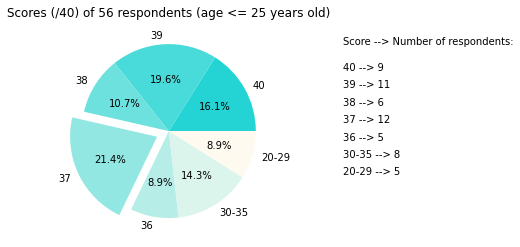

In [68]:
data = [
    scores_summary.iloc[12]["Counts"].sum(), scores_summary.iloc[11]["Counts"].sum(), 
    scores_summary.iloc[10]["Counts"].sum(), scores_summary.iloc[9]["Counts"].sum(), 
    scores_summary.iloc[8]["Counts"].sum(), scores_summary.iloc[4:8]["Counts"].sum(),
    scores_summary.iloc[:4]["Counts"].sum()
]
mylabels = ["40","39","38","37","36","30-35","20-29"]

def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(matplotlib.colors.to_rgb(c1))
    c2=np.array(matplotlib.colors.to_rgb(c2))
    return matplotlib.colors.to_hex((1-mix)*c1 + mix*c2)

c1= "DarkTurquoise"
c2= 'FloralWhite'
n=7

colors = [colorFader(c1,c2,i/n) for i in range(1,8)]

plt.title("Scores (/40) of {} respondents (age <= 25 years old)".format(int(sum(data))))
plt.pie(data, labels = mylabels, explode=[0,0,0,0.15,0,0,0], autopct='%0.1f%%', colors=colors)
plt.text(2,1,"Score --> Number of respondents:")
for i in range(len(mylabels)):
    plt.text(2,0.7-i*0.2,"{} --> {}".format(mylabels[i],int(data[i])))
plt.savefig("pie_under_25yo_{}.png".format(int(sum(data))), dpi=200, bbox_inches="tight")
plt.plot()

In [69]:
humans = get_refined_counts(x)
humans = get_metrics(humans)
humans

,TP,FP,TN,FN,Precision,Recall,Accuracy
"(a, à)",52,6,50,4,0.896552,0.928571,0.910714
"(à, a)",53,5,51,3,0.913793,0.946429,0.928571
"(est, et)",49,2,54,7,0.960784,0.875,0.919643
"(et, est)",53,6,50,3,0.898305,0.946429,0.919643
"(ces, ses)",48,11,45,8,0.813559,0.857143,0.830357
"(ses, ces)",46,1,55,10,0.978723,0.821429,0.901786
"(ce, se)",51,3,53,5,0.944444,0.910714,0.928571
"(se, ce)",50,1,55,6,0.980392,0.892857,0.9375
"(ou, où)",48,4,52,8,0.923077,0.857143,0.892857
"(où, ou)",54,4,52,2,0.931034,0.964286,0.946429


In [70]:
humans.astype(float).mean(axis=0)

TP           49.650000
FP            4.350000
TN           51.650000
FN            6.350000
Precision     0.921120
Recall        0.886607
Accuracy      0.904464
dtype: float64

In [71]:
model = pd.read_csv("Counts-2-8-22-50.csv", header=0, index_col=0,encoding="utf-8")
model = get_metrics(model)
model

,TP,FP,TN,FN,Unexpected,Precision,Recall,Accuracy
"('a', 'à')",407,7,489,87,10,0.983092,0.823887,0.896
"('à', 'a')",428,2,493,63,14,0.995349,0.871690,0.921
"('est', 'et')",395,33,464,89,19,0.922897,0.816116,0.859
"('et', 'est')",303,4,495,183,15,0.986971,0.623457,0.798
"('ces', 'ses')",368,53,440,127,12,0.874109,0.743434,0.808
"('ses', 'ces')",306,34,456,187,17,0.900000,0.620690,0.762
"('ce', 'se')",437,2,488,59,14,0.995444,0.881048,0.925
"('se', 'ce')",426,3,497,62,12,0.993007,0.872951,0.923
"('ou', 'où')",455,27,468,36,14,0.943983,0.926680,0.923
"('où', 'ou')",447,33,464,52,4,0.931250,0.895792,0.911


In [72]:
model.mean(axis=0)

TP            432.950000
FP             18.400000
TN            476.850000
FN             60.400000
Unexpected     11.400000
Precision       0.958978
Recall          0.877176
Accuracy        0.909800
dtype: float64

In [73]:
best_bool, best_text, diff, best_bool_pv, best_text_pv, pvalues, alternatives = compare_metrics(model, humans, HOMOPHONES, pv_limit=0.05)

#### results after considering statistaical test (binomial exact test) and pvalues

In [74]:
best_text_pv

,Precision,Recall,Accuracy
"(a, à)",Transformer,Humans,Undecided
"(à, a)",Transformer,Undecided,Undecided
"(est, et)",Undecided,Undecided,Humans
"(et, est)",Transformer,Humans,Humans
"(ces, ses)",Undecided,Humans,Undecided
"(ses, ces)",Humans,Humans,Humans
"(ce, se)",Transformer,Undecided,Undecided
"(se, ce)",Undecided,Undecided,Undecided
"(ou, où)",Undecided,Undecided,Undecided
"(où, ou)",Undecided,Undecided,Undecided


In [75]:
pvalues

,Precision,Recall,Accuracy
"(a, à)",0.000445,2.178501e-02,3.750606e-01
"(à, a)",0.000008,5.992559e-02,4.711534e-01
"(est, et)",0.236525,1.675762e-01,3.686365e-02
"(et, est)",0.000122,2.164978e-08,3.666991e-04
"(ces, ses)",0.116872,3.087039e-02,3.223157e-01
"(ses, ces)",0.043989,9.712850e-04,1.298333e-04
"(ce, se)",0.001972,3.312332e-01,5.347638e-01
"(se, ce)",0.300854,4.215577e-01,3.614459e-01
"(ou, où)",0.332620,5.067050e-02,1.535638e-01
"(où, ou)",0.570997,5.973435e-02,1.205918e-01


In [76]:
alternatives # alternative hypothesis for statistical tests

,Precision,Recall,Accuracy
"(a, à)",less,greater,greater
"(à, a)",less,greater,greater
"(est, et)",greater,greater,greater
"(et, est)",less,greater,greater
"(ces, ses)",less,greater,greater
"(ses, ces)",greater,greater,greater
"(ce, se)",less,greater,greater
"(se, ce)",less,greater,greater
"(ou, où)",less,less,less
"(où, ou)",less,greater,greater


#### Count the victories

In [77]:
for winner in ["Transformer","Humans","Undecided"]:
    print(winner)
    print((best_text_pv == winner).sum())
    print((best_text_pv == winner).sum().sum())
    print("")

Transformer
Precision    8
Recall       7
Accuracy     5
dtype: int64
20

Humans
Precision    1
Recall       4
Accuracy     3
dtype: int64
8

Undecided
Precision    11
Recall        9
Accuracy     12
dtype: int64
32

